In [3]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt


In [4]:
def read_tsp_file(file_path):
    """Reads a TSP file in TSPLIB format and extracts city coordinates."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coords_start = lines.index("NODE_COORD_SECTION\n") + 1
    coords_end = lines.index("EOF\n")
    coords = []

    for line in lines[coords_start:coords_end]:
        parts = line.split()
        coords.append((float(parts[1]), float(parts[2])))

    return coords

coord = read_tsp_file("eil51.tsp.txt")

In [5]:
# Calculate pairwise distances
def calculate_distance_matrix(coords):
    n = len(coords)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i, j] = math.sqrt((coords[i][0] - coords[j][0])**2 +
                                                 (coords[i][1] - coords[j][1])**2)
    return distance_matrix

dist_matrix = calculate_distance_matrix(coord)
print(dist_matrix)

[[ 0.         12.36931688 19.20937271 ... 26.40075756 24.20743687
  13.89244399]
 [12.36931688  0.         15.29705854 ... 21.02379604 13.89244399
  21.02379604]
 [19.20937271 15.29705854  0.         ... 36.22154055 27.29468813
  32.55764119]
 ...
 [26.40075756 21.02379604 36.22154055 ...  0.         12.04159458
  21.63330765]
 [24.20743687 13.89244399 27.29468813 ... 12.04159458  0.
  26.17250466]
 [13.89244399 21.02379604 32.55764119 ... 21.63330765 26.17250466
   0.        ]]


In [6]:
# Calculate total path length
def total_path_length(path, distance_matrix):
    return sum(distance_matrix[path[i - 1], path[i]] for i in range(len(path)))

In [7]:
# 2-opt move by reconnecting cities
def two_opt_reconnect(route, i, k):
    """
    Perform a 2-opt move by reconnecting the route without swapping the cities directly.
    Deletes two non-adjacent edges and reconnects them to form a new valid circuit.
    
    Args:
        route: A list representing the current route (list of city indices).
        i: Index of the first edge to be deleted.
        k: Index of the second edge to be deleted (k > i).
    
    Returns:
        A new route after performing the 2-opt move.
    """
    # Ensure i and k are valid
    if i >= k or i < 0 or k >= len(route):
        raise ValueError("Invalid indices for 2-opt move")
    
    # Reconnect the path
    new_route = route[:i + 1] + route[k:i:-1] + route[k + 1:]
    return new_route


In [27]:
# Cooling Strategies
def geometric_cooling(temp, cooling_rate):
    return temp * cooling_rate

def linear_cooling(temp, cooling_rate):
    return temp - cooling_rate

def logarithmic_cooling(temp, iteration):
    return temp / math.log(iteration + 1)

def exponential_cooling(temp, cooling_rate, iteration):
    return temp * np.exp(-cooling_rate * iteration)

In [51]:
# Simulated Annealing

def simulated_annealing(distance_matrix, initial_temp, cooling_strategy, markov_length, max_iter=500, cooling_factor=None):
    n = len(distance_matrix)
    current_solution = list(range(n))
    random.shuffle(current_solution)
    current_cost = total_path_length(current_solution, distance_matrix)
   
    best_solution = current_solution
    best_cost = current_cost

    temperature = initial_temp
    iteration = 1

    while temperature > 1e-3:
        for _ in range(markov_length):
            i, k = sorted(random.sample(range(n), 2))  # Random indices for 2-opt
            new_solution = two_opt_reconnect(current_solution, i, k)
            new_cost = total_path_length(new_solution, distance_matrix)

            if new_cost < current_cost or random.random() < math.exp((current_cost - new_cost) / temperature):
                current_solution = new_solution
                current_cost = new_cost

                if current_cost < best_cost:
                    best_solution = current_solution
                    best_cost = current_cost

        if cooling_strategy == "geometric_cooling_strategy":  
            new_temperature = geometric_cooling(temperature, cooling_factor)
        elif cooling_strategy == "linear_cooling_strategy":
            new_temperature = linear_cooling(temperature, cooling_factor)
        elif cooling_strategy == "logarithmic_cooling_strategy":
            new_temperature = logarithmic_cooling(temperature, iteration)
        elif cooling_strategy == "exponential_cooling_strategy":
            new_temperature = exponential_cooling(temperature, cooling_factor, iteration)

        temperature = new_temperature
        iteration += 1
        if iteration > max_iter:
            break

    return best_solution, best_cost

In [33]:
# Parameters
initial_temp = 1000
cooling_rate = 0.995
markov_length = 100
max_iter = 1000

# Run the algorithm
best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "geometric_cooling_strategy" , markov_length, max_iter, cooling_rate)

# Output the results
print("Best Solution:", best_solution)
print("Best Cost:", best_cost)

Best Solution: [31, 10, 37, 4, 36, 16, 3, 17, 46, 11, 45, 50, 5, 47, 22, 6, 42, 23, 13, 24, 12, 40, 39, 18, 41, 43, 14, 44, 32, 38, 29, 9, 48, 8, 15, 49, 33, 20, 28, 1, 19, 34, 35, 2, 27, 30, 25, 7, 21, 0, 26]
Best Cost: 436.76317802827873


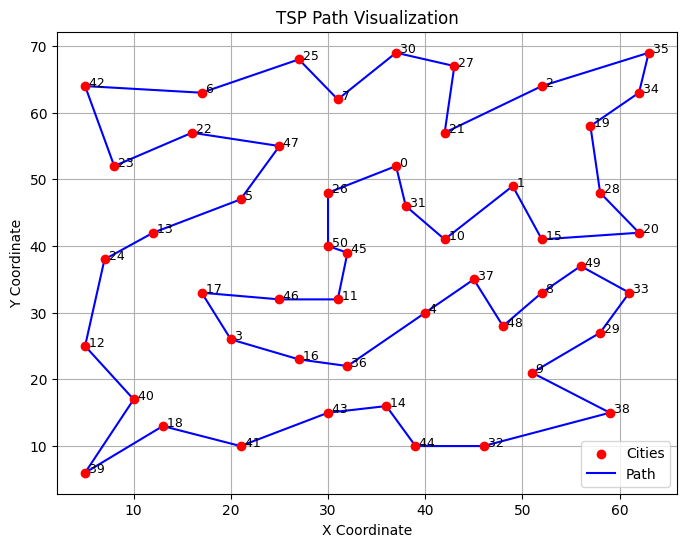

In [18]:

def plot_tsp_path(cities, route):
    """
    Plot the cities and the path connecting them.
    
    Args:
        cities: A list of tuples representing the coordinates of cities (e.g., [(x1, y1), (x2, y2), ...]).
        route: A list of indices representing the order in which cities are visited.
    """
    # Extract coordinates in the order of the route
    x_coords = [cities[i][0] for i in route] + [cities[route[0]][0]]
    y_coords = [cities[i][1] for i in route] + [cities[route[0]][1]]
    
    # Plot cities
    plt.figure(figsize=(8, 6))
    plt.scatter(*zip(*cities), color='red', label='Cities', zorder=3)
    for idx, (x, y) in enumerate(cities):
        plt.text(x, y, f' {idx}', fontsize=9, zorder=4)
    
    # Plot the path
    plt.plot(x_coords, y_coords, color='blue', linestyle='-', linewidth=1.5, label='Path', zorder=2)
    
    # Add details
    plt.title("TSP Path Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_tsp_path(coord, best_solution)

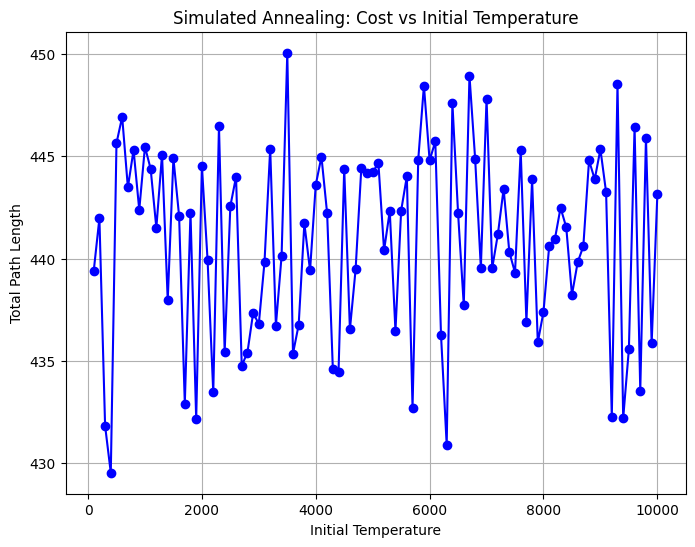

In [12]:
# Parameters
initial_temp = np.linspace(100, 10000, 100)
cost_temp = []
sol_temp = []
cooling_rate = 0.995
markov_length = 100
max_iter = 1000


for temp in initial_temp:
    best_solution, best_cost = simulated_annealing(dist_matrix, temp,geometric_cooling, markov_length, max_iter, cooling_rate)
    sol_temp.append(best_solution)
    cost_temp.append(best_cost)

plt.figure(figsize=(8, 6))
plt.plot(initial_temp, cost_temp, marker='o', color='blue')
plt.title("Simulated Annealing: Cost vs Initial Temperature")
plt.xlabel("Initial Temperature")
plt.ylabel("Total Path Length")
plt.grid(True)
plt.show()


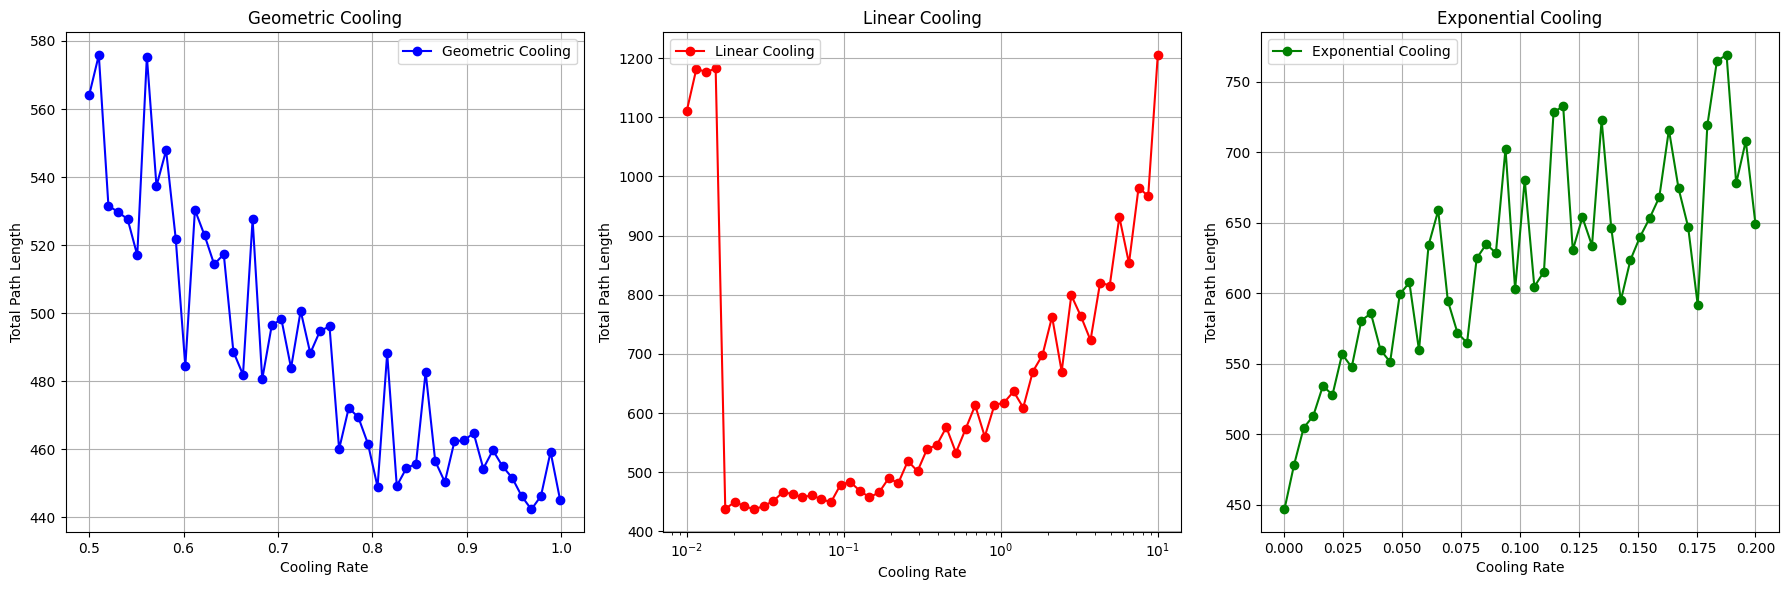

Geometric Cooling: Best Cost: 442.2806799466608
Linear Cooling: Best Cost: 437.1517745334514
Exponential Cooling: Best Cost: 446.7586446953494
Logarithmic Cooling: Best Cost: 659.5350076242354


In [57]:
# Parameters
initial_temp = 1000
markov_length = 100
max_iter = 60000

# Geomnetric Cooling
rates_geo = np.linspace(0.5, 0.999, 50)
cost_geo = []
sol_geo = []

# Linear Cooling
rates_linear = np.logspace(-2, 1, 50)
cost_linear = []
sol_linear = []

# Exponential Cooling
rates_exp = np.linspace(0.0001, 0.2, 50)
cost_exp = []
sol_exp = []

for rate in rates_geo:
    best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "geometric_cooling_strategy", markov_length, max_iter ,rate)
    sol_geo.append(best_solution)
    cost_geo.append(best_cost)

for rate in rates_linear:
    best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "linear_cooling_strategy", markov_length, max_iter, rate)
    sol_linear.append(best_solution)
    cost_linear.append(best_cost)

for rate in rates_exp:
    best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "exponential_cooling_strategy", markov_length, max_iter, rate)
    sol_exp.append(best_solution)
    cost_exp.append(best_cost)

best_solution, cost_log = simulated_annealing(dist_matrix, initial_temp, "logarithmic_cooling_strategy", markov_length, max_iter)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Geometric Cooling
axes[0].plot(rates_geo, cost_geo, marker='o', color='blue', label='Geometric Cooling')
axes[0].set_title("Geometric Cooling")
axes[0].set_xlabel("Cooling Rate")
axes[0].set_ylabel("Total Path Length")
axes[0].legend()
axes[0].grid(True)

# Linear Cooling
axes[1].semilogx(rates_linear, cost_linear, marker='o', color='red', label='Linear Cooling')
axes[1].set_title("Linear Cooling")
axes[1].set_xlabel("Cooling Rate")
axes[1].set_ylabel("Total Path Length")
axes[1].legend()
axes[1].grid(True)

# Exponential Cooling
axes[2].plot(rates_exp, cost_exp, marker='o', color='green', label='Exponential Cooling')
axes[2].set_title("Exponential Cooling")
axes[2].set_xlabel("Cooling Rate")
axes[2].set_ylabel("Total Path Length")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("Geometric Cooling: Best Cost:", min(cost_geo))
print("Linear Cooling: Best Cost:", min(cost_linear))
print("Exponential Cooling: Best Cost:", min(cost_exp))
print("Logarithmic Cooling: Best Cost:", cost_log)


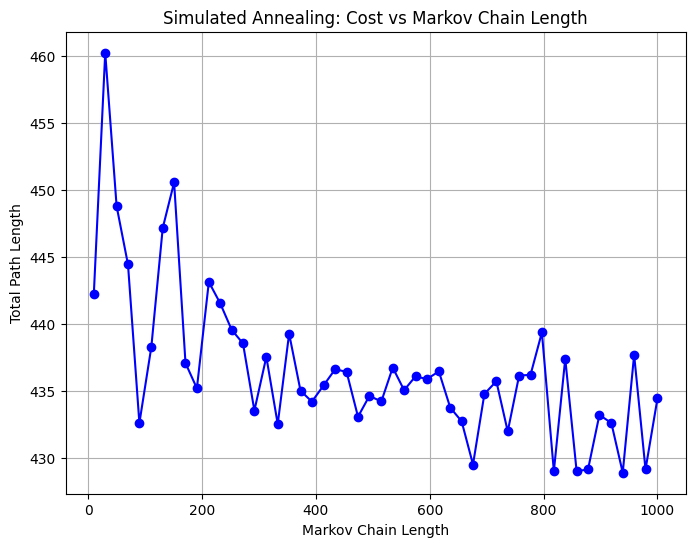

In [58]:
# Parameters
markov_lengths = np.linspace(10, 1000, 50, dtype=int)
initial_temp = 1000
cooling_rate = 0.995
max_iter = 5000

cost_markov = []
sol_markov = []

for markov_length in markov_lengths:
    best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "geometric_cooling_strategy", markov_length, max_iter, cooling_rate)
    sol_markov.append(best_solution)
    cost_markov.append(best_cost)

plt.figure(figsize=(8, 6))
plt.plot(markov_lengths, cost_markov, marker='o', color='blue')
plt.title("Simulated Annealing: Cost vs Markov Chain Length")
plt.xlabel("Markov Chain Length")
plt.ylabel("Total Path Length")
plt.grid(True)
plt.show()

Best Solution: [46, 3, 17, 13, 24, 12, 40, 39, 18, 41, 43, 16, 36, 14, 44, 32, 38, 9, 48, 4, 37, 10, 31, 0, 21, 1, 15, 49, 8, 29, 33, 20, 28, 19, 34, 35, 2, 27, 30, 7, 25, 6, 42, 23, 22, 47, 5, 26, 50, 45, 11]
Best Cost: 428.98164717220675


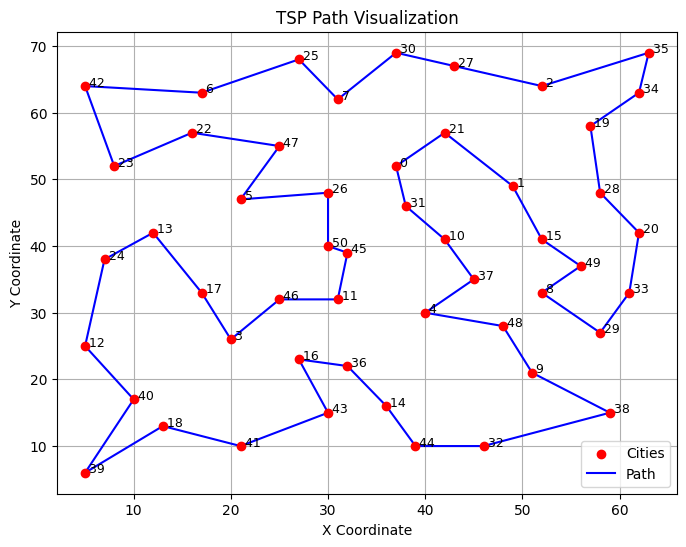

In [61]:
# Optimal Parameters
initial_temp = 2000
cooling_rate = 0.02
markov_length = 850
max_iter = 1000000

best_solution, best_cost = simulated_annealing(dist_matrix, initial_temp, "linear_cooling_strategy", markov_length, max_iter, cooling_rate)

print("Best Solution:", best_solution)
print("Best Cost:", best_cost)

plot_tsp_path(coord, best_solution)

In [65]:
print(len(best_solution))
optimal_tour = [
    1, 22, 8, 26, 31, 28, 3, 36, 35, 20, 2, 29, 21, 16, 50, 34, 30, 9, 49, 
    10, 39, 33, 45, 15, 44, 42, 40, 19, 41, 13, 25, 14, 24, 43, 7, 23, 48, 
    6, 27, 51, 46, 12, 47, 18, 4, 17, 37, 5, 38, 11, 32]
print(len(optimal_tour))

total_path_length(optimal_tour, dist_matrix)

51
51


IndexError: index 51 is out of bounds for axis 1 with size 51